## The project: Bilateral filtering on resliced images 

This project aims to implement and then use a bilateral filtering method, described in the paper “Bilateral
Filtering for Gray and Color Images”, applied on either resampled 2D images or the entire 3D image. The
submitted report should contain, but not limited to, the following aspects

### Implementation of a re-slicing algorithm that obtains an image slice in a non-orthogonal plane, reasonable for viewing prostate gland in 2D images

- 3D affine transformation matrix to rotate and translate the non-orthogonal plane to align it with original coordinate system
- Interpolation to sample image to new coordinate points

In [ ]:
# ## Set up ##
# # Install simpleitk
# ! pip install SimpleITK 

# # Read gipl image using SimpleITK
# import SimpleITK as sitk
# image = sitk.ReadImage("test_trus.gipl")

# # Convert to numpy array
# import numpy as np
# image_array = sitk.GetArrayFromImage(image)

# # Save nump array as .npy file
# np.save("test_trus.npy", image_array)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = np.load("test_trus.npy").T
print("Image shape:", image.shape)


Image shape: (455, 325, 46)


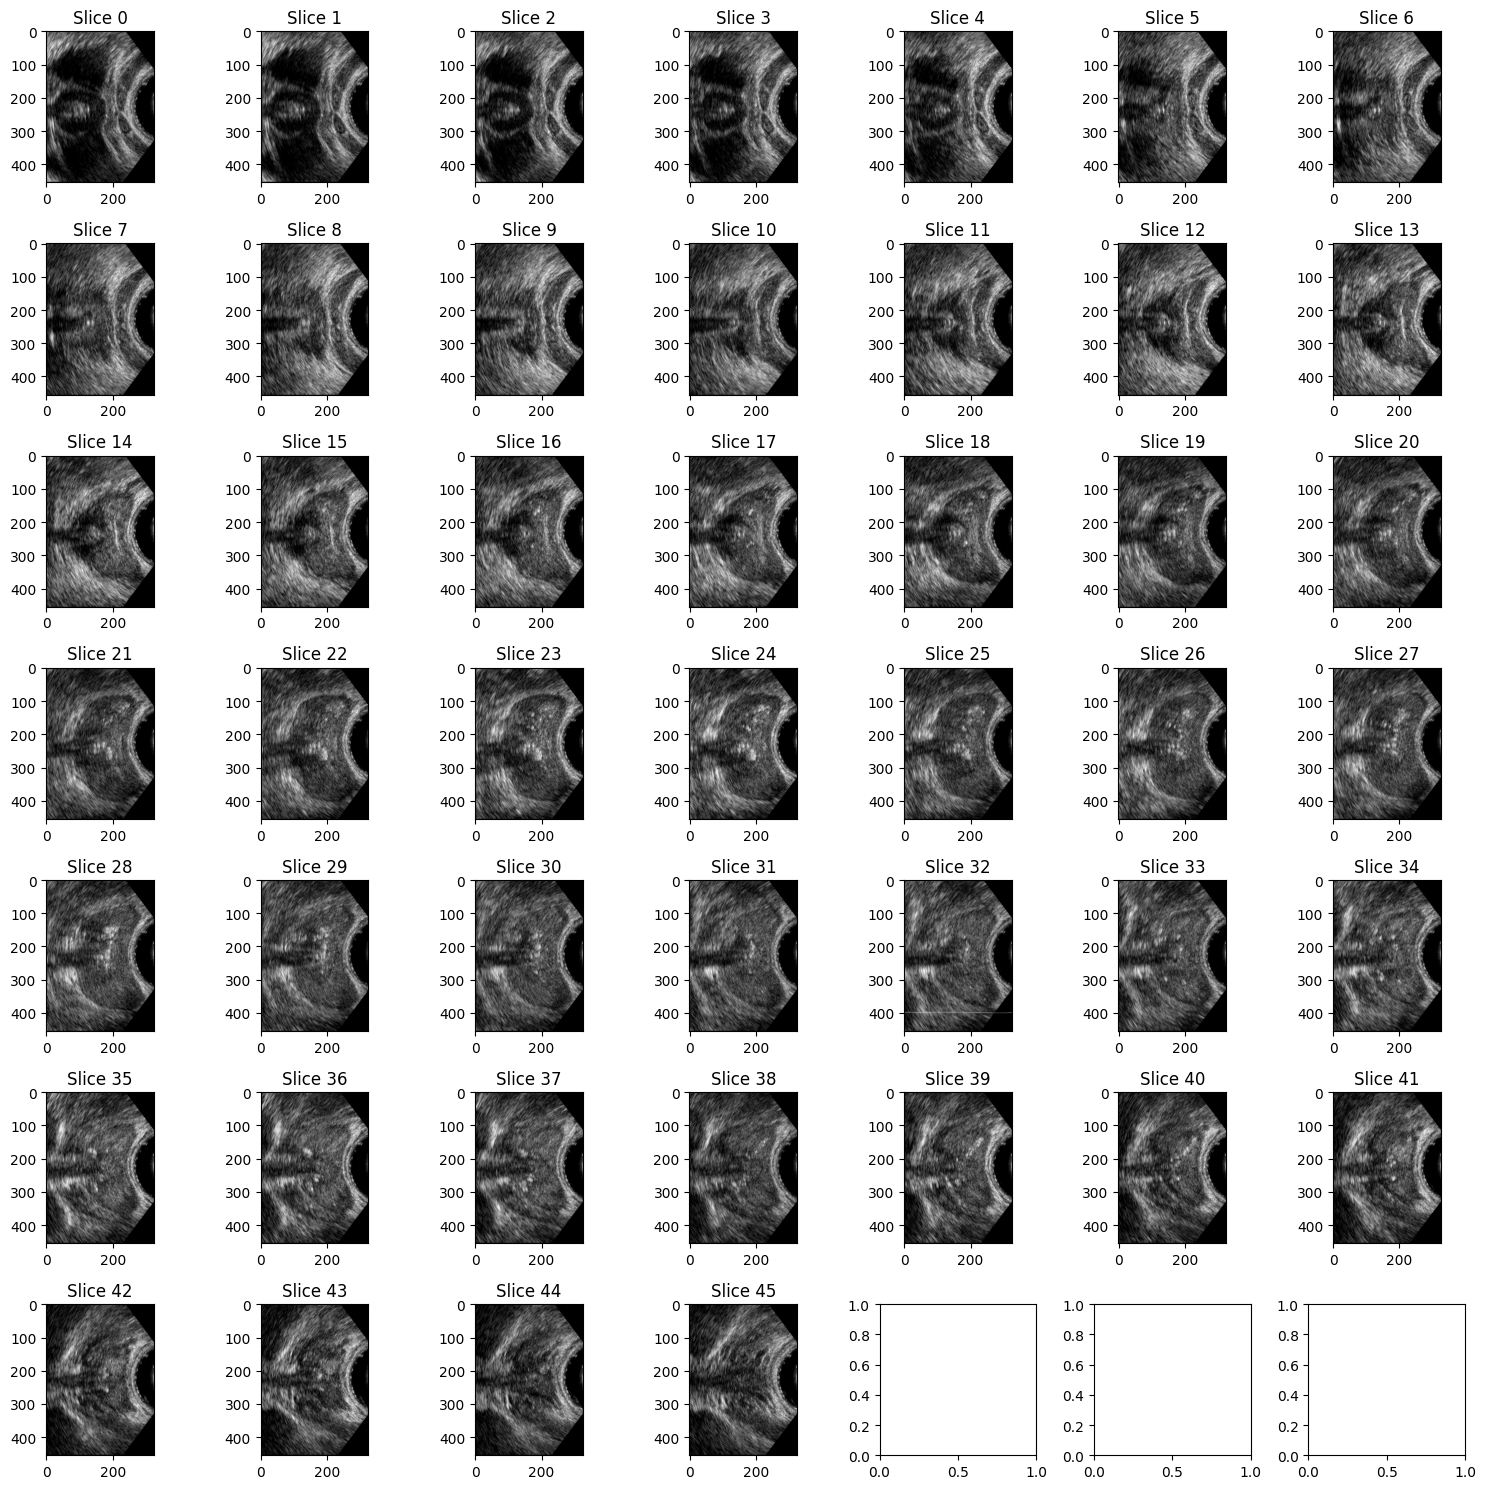

In [2]:

# Visualize slices
n_rows = 7
n_cols = 7

# Create a figure with a subplot grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Iterate over the slices of the image
for row in range(n_rows):
    for col in range(n_cols):
        slice_idx = row * n_cols + col
        if slice_idx >= image.shape[2]:
            break
        slice_data = image[:, :, slice_idx]
        axs[row, col].imshow(slice_data, cmap='gray')
        # Add title to each subplot
        axs[row, col].set_title(f'Slice {slice_idx}')

# Adjust the layout and show the figure
plt.tight_layout()
plt.show()

Implement a re-slicing algorithm that obtains an image slice in a non-orthogonal plane, reasonable for viewing prostate gland in 2D images.

**Non-orthogonal plane**: A plane not perpendicular to the main axes of a coordinate system. In medical imaging, they can be used to view specific structures in a favourable orientation.


- 3D affine transformation matrix to rotate and translate the non-orthogonal plane to align it with original coordinate system
- Interpolation to sample image to new coordinate points

Translation vector is defined as the difference between the point on the plane and the origin of the image coordinate system.

array([227., 162.])

In [2]:
points =(np.array(image[:, :, 0].shape) - 1)/2
angle = 5
angle = np.deg2rad(angle)
# First apply translation to the centre of the image
T1 = np.matrix([[1, 0, -points[0]], [0, 1, -points[1]], [0 ,0 ,1]])
# Then apply rotation
#R = affineMatrixForRotationAboutPoint(angle, points)
R = np.matrix([[np.cos(angle), -np.sin(angle), 0],[np.sin(angle), np.cos(angle), 0], [0,0,1]])
# Then apply translation back to the original centre of the image
T2 = np.matrix([[1, 0, points[0]], [0, 1, points[1]], [0,0,1]])

# Combine the three affine matrices into one (multiplication from last transformation to first)
T = T2*R*T1

# Create a deformation field from the affine matrix
from utils2 import defFieldFromAffineMatrix
def_field = defFieldFromAffineMatrix(T, image.shape[0], image.shape[1])

# Resample the image using the deformation field
from utils2 import resampImageWithDefField
img_resampled_linear = resampImageWithDefField(image, def_field, interp_method = 'linear', pad_value=0)

In [5]:
T

matrix([[  0.9961947 ,  -0.08715574,  14.98303386],
        [  0.08715574,   0.9961947 , -19.16789469],
        [  0.        ,   0.        ,   1.        ]])

In [4]:
def_field

array([[[ 14.98303386, -19.16789469],
        [ 14.89587812, -18.1717    ],
        [ 14.80872237, -17.1755053 ],
        ...,
        [-13.08111531, 301.60679809],
        [-13.16827105, 302.60299279],
        [-13.25542679, 303.59918749]],

       [[ 15.97922856, -19.08073895],
        [ 15.89207281, -18.08454425],
        [ 15.80491707, -17.08834956],
        ...,
        [-12.08492061, 301.69395383],
        [-12.17207635, 302.69014853],
        [-12.25923209, 303.68634323]],

       [[ 16.97542325, -18.99358321],
        [ 16.88826751, -17.99738851],
        [ 16.80111177, -17.00119381],
        ...,
        [-11.08872591, 301.78110958],
        [-11.17588165, 302.77730427],
        [-11.2630374 , 303.77349897]],

       ...,

       [[465.2630374 ,  20.22650103],
        [465.17588165,  21.22269573],
        [465.08872591,  22.21889042],
        ...,
        [437.19888823, 341.00119381],
        [437.11173249, 341.99738851],
        [437.02457675, 342.99358321]],

       [[466.25

In [3]:
img_resampled_linear.shape

(455, 325, 46)

Text(0.5, 1.0, 'Rescaled')

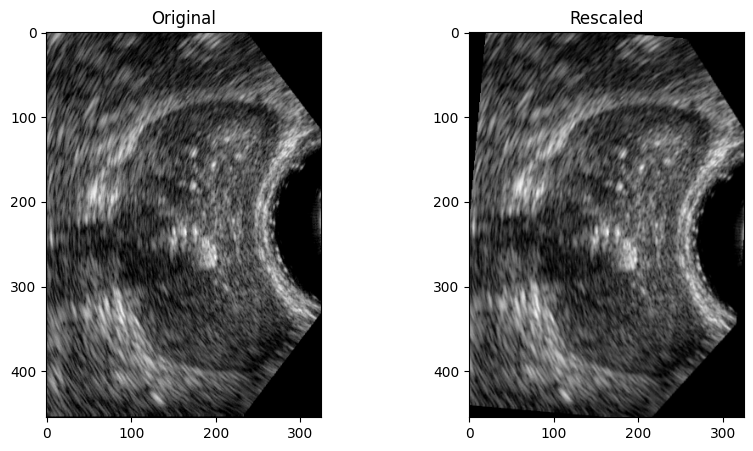

In [4]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image[:,:,23], cmap='gray')
ax1.set_title('Original')
ax2.imshow(img_resampled_linear[:,:,23], cmap='gray')
ax2.set_title('Rescaled')

In [7]:
image.shape[1]

325

Text(0.5, 1.0, 'Rescaled')

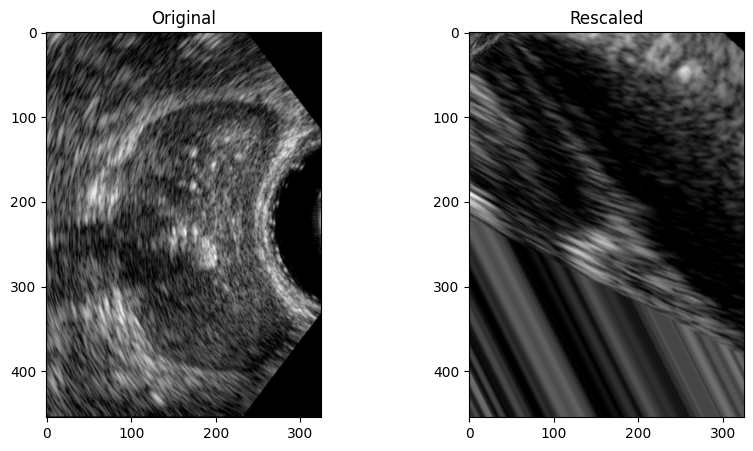

In [3]:
import numpy as np
from scipy.ndimage import affine_transform, map_coordinates

# 3D image data
image = np.load("test_trus.npy").T
#image = np.random.rand(100, 100, 100)

# Define the non-orthogonal plane using the normal vector and a point on the plane
normal_vector = np.array([1, 1, 1])
point_on_plane = np.array([227.5, 162.5,  23. ])
translation_vector = point_on_plane

# Create affine transformation matrix
# The first three rows of the matrix are the normal vector
# The last row is the point on the plane
# affine_matrix = np.zeros((4, 4))
# affine_matrix[:3, :3] = normal_vector[:, np.newaxis]
# affine_matrix[:3, 3] = point_on_plane
# affine_matrix[3, 3] = 1


affine_matrix = np.eye(4)
affine_matrix[:3, :3] = np.eye(3) - 2 * np.outer(normal_vector, normal_vector) / np.dot(normal_vector, normal_vector)
affine_matrix[:3, 3] = point_on_plane

# Apply affine transformation
transformed_image = affine_transform(image, affine_matrix, output_shape = image.shape, order=1, mode = 'nearest')



import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image[:,:,23], cmap='gray')
ax1.set_title('Original')
ax2.imshow(transformed_image[:,:,23], cmap='gray')
ax2.set_title('Rescaled')

In [4]:
np.eye(3) - 2 * np.outer(normal_vector, normal_vector) / np.dot(normal_vector, normal_vector)
theta = 60
theta = theta * np.pi / 180
rot_mat = np.matrix([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta), np.cos(theta), 0], [0,0,1]])
point_on_plane = np.array([227.5, 162.5,  23. ])
translation_vector = np.array((455, 325, 46)) - point_on_plane

In [16]:
translation_vector = np.array((20, 20, 23))

Text(0.5, 1.0, 'Rescaled')

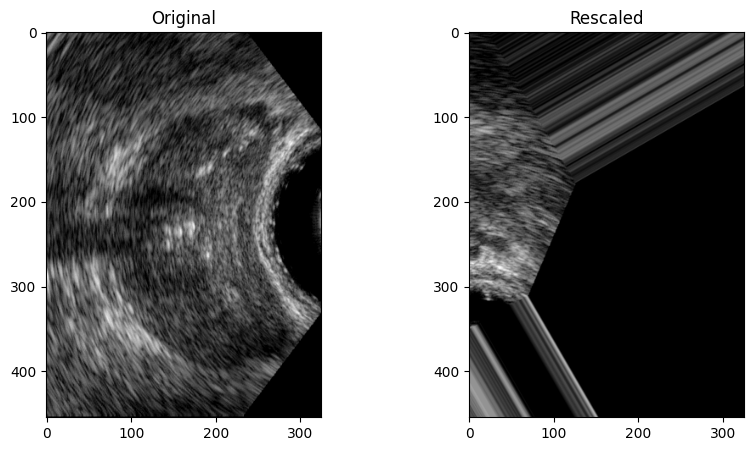

In [17]:
affine_matrix = np.eye(4)
affine_matrix[:3, :3] = rot_mat
affine_matrix[:3, 3] = translation_vector
affine_matrix
transformed_image = affine_transform(image, affine_matrix, output_shape = image.shape, order=3, mode = 'nearest')
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image[:,:,20], cmap='gray')
ax1.set_title('Original')
ax2.imshow(transformed_image[:,:,20], cmap='gray')
ax2.set_title('Rescaled')

In [43]:
transformed_image.shape

(455, 325, 46)

In [24]:
transformed_image.shape / np.array([2])

array([227.5, 162.5,  23. ])

In [16]:
np.dot(normal_vector, normal_vector)

3

In [13]:
affine_matrix = np.zeros((4, 4))
affine_matrix[:3, :3] = normal_vector[:, np.newaxis]
affine_matrix[:3, 3] = point_on_plane
affine_matrix[3, 3] = 1
affine_matrix

array([[ 1.,  1.,  1., 50.],
       [ 1.,  1.,  1., 50.],
       [ 1.,  1.,  1., 50.],
       [ 0.,  0.,  0.,  1.]])

In [4]:
affine_matrix

array([[ 1.,  1.,  1., 50.],
       [ 1.,  1.,  1., 50.],
       [ 1.,  1.,  1., 50.],
       [ 0.,  0.,  0.,  1.]])

In [12]:
affine_matrix = np.eye(4)
affine_matrix[:3, :3] = np.eye(3) - 2 * np.outer(normal_vector, normal_vector) / np.dot(normal_vector, normal_vector)
affine_matrix[:3, 3] = point_on_plane - np.dot(affine_matrix[:3, :3], point_on_plane)
affine_matrix

array([[  0.33333333,  -0.66666667,  -0.66666667, 100.        ],
       [ -0.66666667,   0.33333333,  -0.66666667, 100.        ],
       [ -0.66666667,  -0.66666667,   0.33333333, 100.        ],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [8]:
np.outer(normal_vector, normal_vector) / np.dot(normal_vector, normal_vector)

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [22]:
image

array([[[123, 107, 104, ...,   8,   0,   8],
        [123, 112,  75, ...,   3,   0,   8],
        [123,  88,  72, ...,   8,   9,   3],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[123, 107,  88, ...,   8,   0,  11],
        [120,  80,  64, ...,   8,   0,   0],
        [ 99,  80,  64, ...,  24,   8,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[120,  91,  72, ...,   8,   0,   8],
        [104,  66,  56, ...,  11,   0,   0],
        [ 80,  81,  58, ...,  25,  11,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[195, 185, 184, ...,   0,   8,  17],
        [192, 192, 168, ...,   0,   0,  16],
        [184, 163, 144, ...,   1,   0,   9

In [25]:
# Rotation matrix
rm = np.matrix([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta), np.cos(theta), 0], [0,0,1]])

# Apply rotation
#rotated_image = map_coordinates(image, np.dot(rm, image_coords), order=1, mode='nearest')

In [ ]:
"""
  function to calculate the affine matrix corresponding to an anticlockwise
  rotation about a point
  
  INPUTS:    theta: the angle of the rotation, specified in degrees
             p_coords: the 2D coordinates of the point that is the centre of
                 rotation. p_coords[0] is the x coordinate, p_coords[1] is
                 the y coordinate
  
  OUTPUTS:   aff_mat: a 3 x 3 affine matrix
  """
  # ***************
  # ADD CODE HERE TO IMPLEMENT THE ABOVE FUNCTION

In [23]:
transformed_image.shape 
324/2

162.0

In [30]:
p_coords = np.array([227.5, 162.5, 1])

In [29]:
rm

matrix([[ 0.5      , -0.8660254,  0.       ],
        [ 0.8660254,  0.5      ,  0.       ],
        [ 0.       ,  0.       ,  1.       ]])

In [32]:
aff_mat = np.matmul(rm, p_coords)
aff_mat

matrix([[-26.97912811, 278.27077936,   1.        ]])

In [ ]:
np.matrix([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta), np.cos(theta), 0], [0,0,1]])

In [1]:
import numpy as np
# Calculate the affine matrix corresponding to the rotation
def rotation_matrix(angle, point):
    angle = np.deg2rad(angle)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), (1-np.cos(angle))*point[0]-np.sin(angle)*point[1]],

                               [np.sin(angle), np.cos(angle), np.sin(angle)*point[0]+(1-np.cos(angle))*point[1]],
                               
                               [0, 0, 1]])
    return rotation_matrix




Bad pipe message: %s [b'\x98[\x8f<\x18\xba\xb0\x9b\xd8&\xc2\x9e\xb5\xf3\xaed\xae\xf6 \xfc@|\xb1\x89\xd6\x8d-\xa9P$\x17\xc2\x0e\xd7\xdd\xf9\xed\xf3Oi\xdd7\xd9\xc5i\x03J\xe9\x19\x8f+\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xfa\xaeG\xe3vC\xbc\xa3\xb8\xf9\xe5\x18B\x11\xecK\xe7\x8d\x9e**\x9aX(\xd0']
Bad pipe message: %s [b'\xc1\xc0:\x80\xd8\xb2\xe4\xd0x\x89gIUr\xa51rf\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E\x00D\x00C\x00B\xc0\x18\x004\x00\x9b

## Bilateral filter

In [1]:
# Install opencv
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


Text(0.5, 1.0, 'Rescaled')

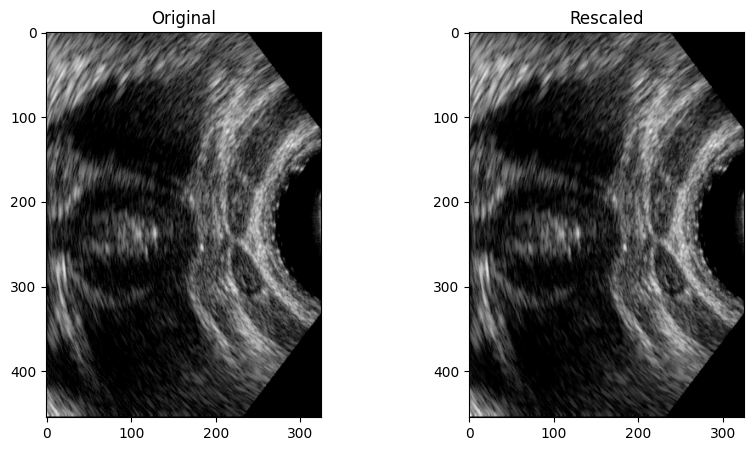

In [35]:
import cv2
import numpy as np

# Apply bilateral filter to image
d = 5
sigmaColor = 5
sigmaSpace = 5
filtered_image = cv2.bilateralFilter(image[:, :, 1], d, sigmaColor, sigmaSpace)

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image[:,:,1], cmap='gray')
ax1.set_title('Original')
ax2.imshow(filtered_image, cmap='gray')
ax2.set_title('Rescaled')

In [41]:
slice_1 = np.double(slice_1)
slice_1.dtype

dtype('float64')

/tmp/ipykernel_14272/2042173446.py:53: RuntimeWarning: invalid value encountered in double_scalars
  filtered_image[x, y] = np.sum(weight * neighborhood) / np.sum(weight)                #


Text(0.5, 1.0, 'Rescaled')

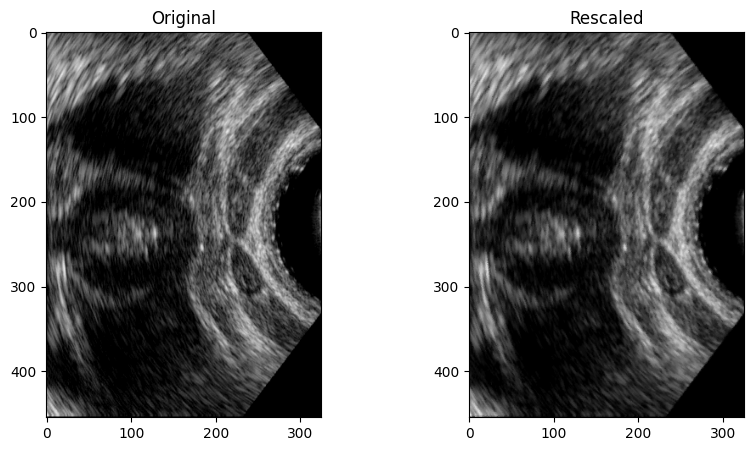

In [43]:
import cv2
import numpy as np

# Apply bilateral filter to image
d = 2
sigmaColor = 5
sigmaSpace = 5
filtered_image = bilateral_filter_2d(image[:, :, 1], d, sigmaColor, sigmaSpace)

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image[:,:,1], cmap='gray')
ax1.set_title('Original')
ax2.imshow(filtered_image, cmap='gray')
ax2.set_title('Rescaled')

/tmp/ipykernel_14272/2412602864.py:53: RuntimeWarning: invalid value encountered in double_scalars
  filtered_image[x, y, z] = np.sum(weight * neighborhood) / np.sum(weight)                #


Text(0.5, 1.0, 'filtered_3d')

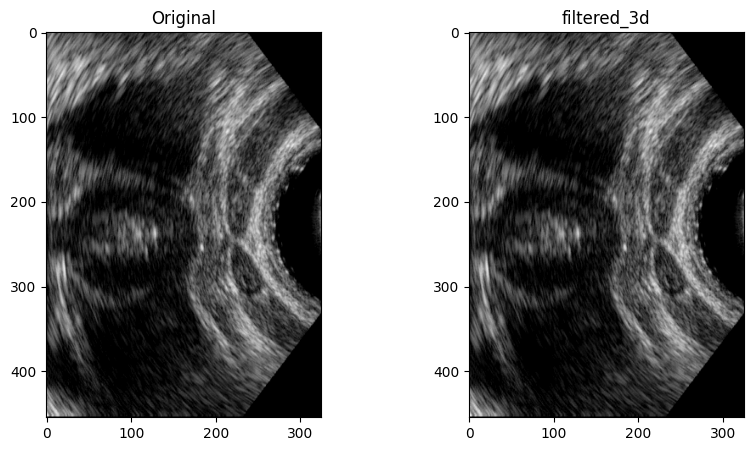

In [27]:
diameter = 1
sigmaColor = 5
sigmaSpace = 5
filtered_3d = bilateral_filter(image[:, :, :2], sigmaColor, sigmaSpace, diameter)
filtered_3d.shape


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image[:,:,1], cmap='gray')
ax1.set_title('Original')
ax2.imshow(filtered_3d[:, :, 1], cmap='gray')
ax2.set_title('filtered_3d')

In [10]:
filtered_image.shape

(455, 325)

In [ ]:
import SimpleITK as sitk

# Apply bilateral filter to 3d image
domain_sigma  = 4.0
range_sigma = 50.0

#Create bilateral filter
bilateralfilter = sitk.BilateralImageFilter()
bilateralfilter.SetDomainSigma(domain_sigma)
bilateralfilter.SetRangeSigma(range_sigma)

filtered_image = bilateralfilter.Execute(image[:, :, 1])

In [2]:
from scipy.ndimage import gaussian_filter
d = 9
sigmaColor = 10
sigmaSpace = 10
filtered_image = gaussian_filter(image, sigma=(sigmaColor, sigmaSpace, sigmaSpace), axis = -1)

TypeError: gaussian_filter() got an unexpected keyword argument 'axis'

## Bilateral filter 3D

This project aims to implement and then use a bilateral filtering method, described in the paper “Bilateral Filtering for Gray and Color Images”, applied on either resampled 2D images or the entire 3D image.

A bilateral filter is a non-linear, edge preserving and noise reducing smoothing filter for images. **It replaces the intensity of each pixel with a weighted average of intensity values from nearby pixels.**

- This weight can be based on a Gaussian distribution.
- The weight does not only depend on the Euclidean distance of pixels, but also on the radiometric differences e.g color intensity 


Therefore, To implement a bilateral filter from scratch that filters a 3D image without having to take individual 2D slices, we can use a nested loop to iterate through each pixel in the 3D image, and then use the intensity and spatial distance of the pixel to compute the weight of the pixel.



In [7]:
# Implement a function to apply a bilateral filter to a 3D image
import numpy as np
from scipy.ndimage import gaussian_filter

def bilateral_filter(image, sigmaColor, sigmaSpace, diameter):
    """
    function to apply a bilateral filter to a 3D image

    A bilateral filter is a non-linear, edge preserving and noise reducing smoothing filter for images.
    **It replaces the intensity of each pixel with a weighted average of intensity values from nearby pixels.**
    
    This weight can be based on a Gaussian distribution.
    The weight does not only depend on the Euclidean distance of pixels, but also on the radiometric differences e.g color intensity 

    INPUTS:    image: a 3D image
                sigmaColor: the standard deviation of the Gaussian function used to weight the color differences
                sigmaSpace: the standard deviation of the Gaussian function used to weight the spatial differences

    OUTPUTS:   filtered_image: the filtered image
    """
    # Create empty array to store filtered image
    filtered_image = np.zeros_like(image)
    spatial_weights = np.zeros_like(image)

    # Compute the Gaussian spatial weights using scipy's gaussian filter
    for i in range(image.shape[-1]):
        spatial_weights[:, :, i] = gaussian_filter(image[:, :, i], sigmaSpace)

    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            for z in range(image.shape[2]):
                # Determine the indices of the neighborhood
                z_start = max(z - diameter // 2, 0)
                z_end = min(z + diameter // 2 + 1, image.shape[2])
                y_start = max(y - diameter // 2, 0)
                y_end = min(y + diameter // 2 + 1, image.shape[1])
                x_start = max(x - diameter // 2, 0)
                x_end = min(x + diameter // 2 + 1, image.shape[0])

                # Select the neighborhood
                neighborhood = image[x_start:x_end, y_start:y_end, z_start:z_end]

                # Compute the Gaussian color intensity weights
                intensity_weight = np.exp(-((image[x, y, z] - neighborhood)**2 / (2 * sigmaColor**2)))

                # Select the spatial weight for the neighborhood
                spatial_weight = spatial_weights[x_start:x_end, y_start:y_end, z_start:z_end]

                # Compute overall weight
                weight = spatial_weight * intensity_weight
                
                # Compute filtered image as  a weighted average of intensity values from nearby pixels
                filtered_image[x, y, z] = np.sum(weight * neighborhood) / np.sum(weight)                # 
                # neighborhood_sum = np.sum(weight * neighborhood)
                # neighborhood_sum_of_weights = np.sum(weight)

    return filtered_image

                
    

In [16]:
# Implement a function to apply a bilateral filter to a 3D image
import numpy as np
from scipy.ndimage import gaussian_filter

def bilateral_filter_2d(image, diameter, sigmaColor, sigmaSpace):
    """
    function to apply a bilateral filter to a 3D image

    A bilateral filter is a non-linear, edge preserving and noise reducing smoothing filter for images.
    **It replaces the intensity of each pixel with a weighted average of intensity values from nearby pixels.**
    
    This weight can be based on a Gaussian distribution.
    The weight does not only depend on the Euclidean distance of pixels, but also on the radiometric differences e.g color intensity 

    INPUTS:    image: a 3D image
                sigmaColor: the standard deviation of the Gaussian function used to weight the color differences
                sigmaSpace: the standard deviation of the Gaussian function used to weight the spatial differences

    OUTPUTS:   filtered_image: the filtered image
    """
    # Create empty array to store filtered image
    filtered_image = np.zeros_like(image)
    spatial_weights = np.zeros_like(image)

    # Compute the Gaussian spatial weights using scipy's gaussian filter
    
   # spatial_weights = gaussian_filter(image, sigmaSpace)
    
    # for x in range(image.shape[0]):
    #     for y in range(image.shape[1]):
    #             # Compute the Gaussian spatial weight
    #         spatial_weight = np.exp(-(x**2 + y**2) / (2*sigmaSpace**2))

    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            #for z in range(image.shape[2]):
                # Determine the indices of the neighborhood
                # z_start = max(z - diameter // 2, 0)
                # z_end = min(z + diameter // 2 + 1, image.shape[2])
                y_start = max(y - diameter // 2, 0)
                y_end = min(y + diameter // 2 + 1, image.shape[1])
                x_start = max(x - diameter // 2, 0)
                x_end = min(x + diameter // 2 + 1, image.shape[0])

                # Select the neighborhood
                neighborhood = image[x_start:x_end, y_start:y_end]

                # Compute the Gaussian color intensity weights
                intensity_weight = np.exp(-((image[x, y] - neighborhood)**2 / (2 * sigmaColor**2)))

                # Select the spatial weight for the neighborhood
                #spatial_weight = spatial_weights[x_start:x_end, y_start:y_end]
                #dist = np.sqrt((x - x_start)**2 + (y - y_start)**2)
                #spatial_weight = np.exp(-(dist**2) / (2*sigmaSpace**2))
                #spatial_weight = np.exp(-(x**2 + y**2) / (2*sigmaSpace**2))

                spatial_weight = gaussian_filter(neighborhood, sigmaSpace)

                # Compute overall weight
                weight = spatial_weight * intensity_weight
                
                # Compute filtered image as  a weighted average of intensity values from nearby pixels
                filtered_image[x, y] = np.sum(weight * neighborhood) / np.sum(weight)                # 
                # neighborhood_sum = np.sum(weight * neighborhood)
                # neighborhood_sum_of_weights = np.sum(weight)

    return filtered_image

                
    

In [ ]:
for z in range(img.shape[0]):
        for y in range(img.shape[1]):
            for x in range(img.shape[2]):
                # Compute the Gaussian spatial weight
                spatial_weight = np.exp(-(x**2 + y**2 + z**2) / (2*sigmaSpace**2))

In [33]:
slice_1 = image[:, :, 1]

107

In [ ]:
# import numpy as np
# from scipy.ndimage.filters import gaussian_filter

# def bilateral_filter(img, sigmaColor, sigmaSpace, diameter):
#     filtered_img = np.zeros_like(img)
#     spatial_weights = np.zeros_like(img)
    
#     # Compute the Gaussian spatial weights using scipy's gaussian_filter
#     for i in range(img.shape[0]):
#         spatial_weights[i, :, :] = gaussian_filter(img[i, :, :], sigmaSpace)
    
#     for z in range(img.shape[0]):
#         for y in range(img.shape[1]):
#             for x in range(img.shape[2]):
#                 # Determine the indices of the neighborhood
#                 z_start = max(z - diameter // 2, 0)
#                 z_end = min(z + diameter // 2 + 1, img.shape[0])
#                 y_start = max(y - diameter // 2, 0)
#                 y_end = min(y + diameter // 2 + 1, img.shape[1])
#                 x_start = max(x - diameter // 2, 0)
#                 x_end = min(x + diameter // 2 + 1, img.shape[2])
                
#                 # Select the neighborhood
#                 neighborhood = img[z_start:z_end, y_start:y_end, x_start:x_end]
                
#                 # Compute the Gaussian intensity weight
#                 intensity_weight = np.exp(-(img[z, y, x] - neighborhood)**2 / (2*sigmaColor**2))
                
#                 # Select the spatial weight for the neighborhood
#                 spatial_weight = spatial_weights[z_start:z_end, y_start:y_end, x_start:x_end]
                
#                 # Compute the overall weight
#                 weight = spatial_weight * intensity_weight
                
#                 # Accumulate the weighted neighborhood sum
#                 neighborhood_sum = np.sum(weight * neighborhood)
#                 neighborhood_weight_sum = np.sum(weight)
                
#                 # Compute the filtered pixel value
#                 filtered_img[z, y, x] = neighborhood_sum / neighborhood_weight_sum
#     return filtered_img


In [11]:
np.exp(-(image[0, 0, 0] - image)**2 / (2*5**2)).shape

(455, 325, 46)

In [7]:
image[:, :, :5].shape

(455, 325, 5)

In [2]:
filtered_3d = np.load('filtered_3d.npy')

In [6]:
image.shape

(455, 325, 46)

In [11]:
image[:, :, :2].shape

(455, 325, 2)

/tmp/ipykernel_14272/2412602864.py:53: RuntimeWarning: invalid value encountered in double_scalars
  filtered_image[x, y, z] = np.sum(weight * neighborhood) / np.sum(weight)                #


(455, 325, 2)

In [4]:
np.save("filtered_3d.npy", filtered_3d)

In [22]:
sigmaColor = 10
sigmaSpace = 1
filtered_image = np.zeros_like(image)
spatial_weights = np.zeros_like(image)
spatial_weights[:, :, 0] = gaussian_filter(image[:, :, 0], sigmaSpace)

In [23]:
for i in range(image.shape[-1]):
    spatial_weights[:, :, i] = gaussian_filter(image[:, :, i], sigmaSpace)

In [ ]:
spatial_weights[:, :, i] = gaussian_filter(image[:, :, i], sigmaSpace)

In [12]:
image.shape

(455, 325, 46)

In [4]:
import numpy as np
from scipy.ndimage import gaussian_filter

def bilateral_filter(img, sigmaColor, sigmaSpace):
    filtered_img = np.zeros_like(img)
    spatial_weights = np.zeros_like(img)
    
    # Compute the Gaussian spatial weights using scipy's gaussian_filter
    for i in range(img.shape[0]):
        spatial_weights[i, :, :] = gaussian_filter(img[i, :, :], sigmaSpace)
    
    for z in range(img.shape[0]):
        for y in range(img.shape[1]):
            for x in range(img.shape[2]):
                # Compute the Gaussian intensity weight
                intensity_weight = np.exp(-(img[z, y, x] - img)**2 / (2*sigmaColor**2))
                
                # Compute the overall weight
                weight = spatial_weights * intensity_weight
                
                # Accumulate the weighted neighborhood sum
                neighborhood_sum = np.sum(weight * img)
                neighborhood_weight_sum = np.sum(weight)
                
                # Compute the filtered pixel value
                filtered_img[z, y, x] = neighborhood_sum / neighborhood_weight_sum
    return filtered_img


In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image[:,:,1], cmap='gray')
ax1.set_title('Original')
ax2.imshow(filtered_3d[:, :, 1], cmap='gray')
ax2.set_title('Bilateral Filtered')

In [11]:
# Using a gaussina weighting function]
import numpy as np
from scipy.ndimage.filters import gaussian_filter

def bilateral_filter(img, sigmaColor, sigmaSpace):
    filtered_img = np.zeros_like(img)
    for z in range(img.shape[0]):
        for y in range(img.shape[1]):
            for x in range(img.shape[2]):
                # Compute the Gaussian spatial weight
                spatial_weight = np.exp(-(x**2 + y**2 + z**2) / (2*sigmaSpace**2))
                
                # Iterate through the neighborhood
                neighborhood_sum = 0
                neighborhood_weight_sum = 0
                for z_n in range(z-1, z+2):
                    for y_n in range(y-1, y+2):
                        for x_n in range(x-1, x+2):
                            # Check if the neighborhood pixel is within the image bounds
                            if (0 <= z_n < img.shape[0]) and (0 <= y_n < img.shape[1]) and (0 <= x_n < img.shape[2]):
                                # Compute the Gaussian intensity weight
                                intensity_weight = np.exp(-(img[z_n, y_n, x_n] - img[z, y, x])**2 / (2*sigmaColor**2))
                                
                                # Compute the overall weight
                                weight = spatial_weight * intensity_weight
                                
                                # Accumulate the weighted neighborhood sum
                                neighborhood_sum += weight * img[z_n, y_n, x_n]
                                neighborhood_weight_sum += weight
                
                # Compute the filtered pixel value
                filtered_img[z, y, x] = neighborhood_sum / neighborhood_weight_sum
    return filtered_img


/tmp/ipykernel_18246/1290952174.py:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [3]:
import cv2
import numpy as np

def gaussian(x,sigma):
    return ((np.sqrt(2*np.pi)*sigma)**-1)*np.exp(-0.5 * (x/sigma)**2)

def distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def bilateral_filter(image, diameter, sigma_i, sigma_s):
    new_image = np.zeros(image.shape)

    






In [4]:
np.sqrt(4)

2.0

In [18]:
import cv2
import numpy

def gaussian(x,sigma):
    return (1.0/(2*numpy.pi*(sigma**2)))*numpy.exp(-(x**2)/(2*(sigma**2)))

def distance(x1,y1,x2,y2):
    return numpy.sqrt(numpy.abs((x1-x2)**2-(y1-y2)**2))

def bilateral_filter(image, diameter, sigma_i, sigma_s):
    new_image = numpy.zeros(image.shape)

    for row in range(len(image)):
        for col in range(len(image[0])):
            wp_total = 0
            filtered_image = 0
            for k in range(diameter):
                for l in range(diameter):
                    n_x =row - (diameter/2 - k)
                    n_y =col - (diameter/2 - l)
                    if n_x >= len(image):
                        n_x -= len(image)
                    if n_y >= len(image[0]):
                        n_y -= len(image[0])
                    gi = gaussian(image[int(n_x)][int(n_y)] - image[row][col], sigma_i)
                    gs = gaussian(distance(n_x, n_y, row, col), sigma_s)
                    wp = gi * gs
                    filtered_image = (filtered_image) + (image[int(n_x)][int(n_y)] * wp)
                    wp_total = wp_total + wp
            filtered_image = filtered_image // wp_total
            new_image[row][col] = int(numpy.round(filtered_image))
    return new_image

# image = cv2.imread("in_img.jpg",0)
# filtered_image_OpenCV = cv2.bilateralFilter(image, 7, 20.0, 20.0)
# cv2.imwrite("filtered_image_OpenCV.png", filtered_image_OpenCV)
# image_own = bilateral_filter(image, 7, 20.0, 20.0)
# cv2.imwrite("filtered_image_own.png", image_own)


In [6]:
# Download image from link
link = "https://raw.githubusercontent.com/nuwandda/Bilateral-Filter/master/in_img.jpg"

# Download
!wget -q -O img.jpg $link

True

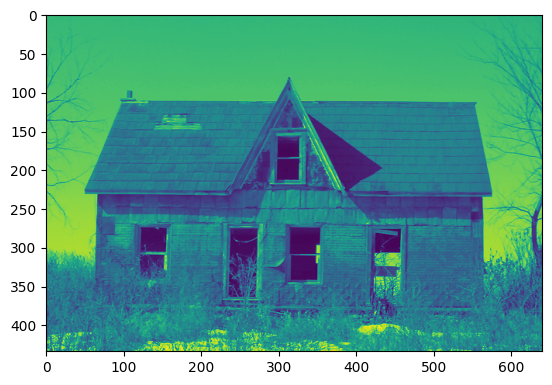

In [5]:
import matplotlib.pyplot as plt
import cv2
image = cv2.imread("img.jpg",0)
filtered_image_OpenCV = cv2.bilateralFilter(image, 2, 20.0, 20.0)
plt.imshow(filtered_image_OpenCV)
cv2.imwrite("filtered_image_OpenCV.png", filtered_image_OpenCV)

In [ ]:
mine = bilateral_filter_2d(image, 1, 20.0, 20.0)
cv2.imwrite("mine.png", mine)

In [15]:
image_own = bilateral_filter(image, 7, 20.0, 20.0)
cv2.imwrite("filtered_image_own.png", image_own)


NameError: name 'bilateral_filter' is not defined

In [21]:
image

In [13]:
import numpy as np
from scipy.ndimage import gaussian_filter

def bilateral_filter_2d(img, sigmaColor, sigmaSpace):
    filtered_img = np.zeros_like(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            #for z in range(img.shape[2]):
                # Compute the Gaussian spatial weight
            spatial_weight = np.exp(-(x**2 + y**2) / (2*sigmaSpace**2))
            
            # Iterate through the neighborhood
            neighborhood_sum = 0
            neighborhood_weight_sum = 0
            for x_n in range(x-1, x+2):
                for y_n in range(y-1, y+2):
                    #for x_n in range(x-1, x+2):
                        # Check if the neighborhood pixel is within the image bounds
                    if ((0 <= x_n < img.shape[0]) and (0 <= y_n < img.shape[1])):
                        # Compute the Gaussian intensity weight
                        intensity_weight = np.exp(-(img[x_n, y_n] - img[x, y])**2 / (2*sigmaColor**2))
                        
                        # Compute the overall weight
                        weight = spatial_weight * intensity_weight
                        
                        # Accumulate the weighted neighborhood sum
                        neighborhood_sum += weight * img[x_n, y_n]
                        neighborhood_weight_sum += weight
        
            # Compute the filtered pixel value
            filtered_img[x, y] = neighborhood_sum / neighborhood_weight_sum
            
    return filtered_img


In [ ]:
import cv2
import numpy

def gaussian(x,sigma):
    return (1.0/(2*numpy.pi*(sigma**2)))*numpy.exp(-(x**2)/(2*(sigma**2)))

def distance(x1,y1,x2,y2):
    return numpy.sqrt(numpy.abs((x1-x2)**2-(y1-y2)**2))

def bilateral_filter(image, diameter, sigma_i, sigma_s):
    new_image = numpy.zeros(image.shape)

    for row in range(len(image)):
        for col in range(len(image[0])):
            wp_total = 0
            filtered_image = 0
            for k in range(diameter):
                for l in range(diameter):
                    n_x =row - (diameter/2 - k)
                    n_y =col - (diameter/2 - l)
                    if n_x >= len(image):
                        n_x -= len(image)
                    if n_y >= len(image[0]):
                        n_y -= len(image[0])
                    gi = gaussian(image[int(n_x)][int(n_y)] - image[row][col], sigma_i)
                    gs = gaussian(distance(n_x, n_y, row, col), sigma_s)
                    wp = gi * gs
                    filtered_image = (filtered_image) + (image[int(n_x)][int(n_y)] * wp)
                    wp_total = wp_total + wp
            filtered_image = filtered_image // wp_total
            new_image[row][col] = int(numpy.round(filtered_image))
    return new_image

In [25]:
image.shape

(434, 640)

In [24]:
len(image)

434

In [3]:
import numpy as np
import scipy.ndimage as ndimage
from scipy.spatial.distance import cdist

def bilateral_filter(image, diameter, sigma_color, sigma_spatial):
    height, width, depth = image.shape
    filtered_image = np.zeros_like(image)
    for i in range(height):
        for j in range(width):
            for k in range(depth):
                current_pixel = image[i, j, k]
                spatial_differences = cdist(np.array([[i, j, k]]), np.array(np.where(np.ones((height, width, depth)))).T, 'euclidean')
                spatial_weights = np.exp(-0.5 * (spatial_differences / sigma_spatial)**2)
                color_differences = np.abs(image - current_pixel)
                color_weights = np.exp(-0.5 * (color_differences / sigma_color)**2)
                bilateral_weights = color_weights * spatial_weights
                bilateral_weights[spatial_differences > diameter] = 0
                bilateral_weights /= np.sum(bilateral_weights)
                filtered_image[i, j, k] = np.sum(bilateral_weights * image)
    return filtered_image


In [4]:
bs = bilateral_filter(image[:, :, :1], 20.0, 20.0)

/tmp/ipykernel_1267/2954986046.py:21: RuntimeWarning: overflow encountered in ubyte_scalars
  intensity_weight = np.exp(-(img[z_n, y_n, x_n] - img[z, y, x])**2 / (2*sigmaColor**2))


In [6]:
bs.shape

(455, 325, 1)

Text(0.5, 1.0, 'filtered_3d')

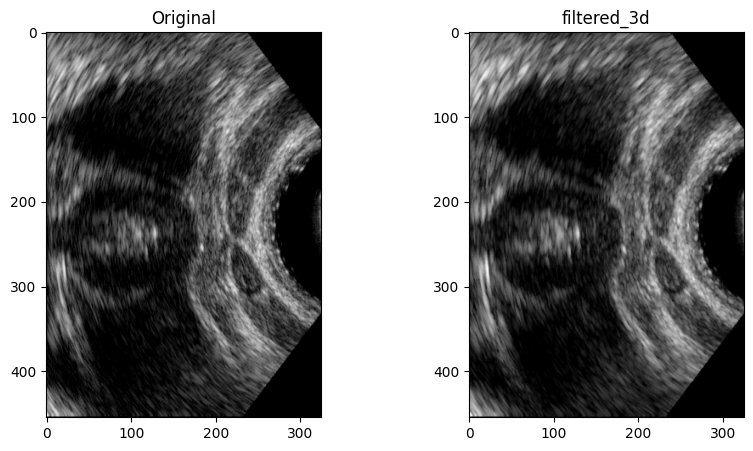

In [7]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image[:,:,1], cmap='gray')
ax1.set_title('Original')
ax2.imshow(bs[:, :, 0], cmap='gray')
ax2.set_title('filtered_3d')

In [2]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter

def bilateral_filter(img, sigmaColor, sigmaSpace):
    filtered_img = np.zeros_like(img)
    for z in range(img.shape[0]):
        for y in range(img.shape[1]):
            for x in range(img.shape[2]):
                # Compute the Gaussian spatial weight
                spatial_weight = np.exp(-(x**2 + y**2 + z**2) / (2*sigmaSpace**2))
                
                # Iterate through the neighborhood
                neighborhood_sum = 0
                neighborhood_weight_sum = 0
                for z_n in range(z-1, z+2):
                    for y_n in range(y-1, y+2):
                        for x_n in range(x-1, x+2):
                            # Check if the neighborhood pixel is within the image bounds
                            if (0 <= z_n < img.shape[0]) and (0 <= y_n < img.shape[1]) and (0 <= x_n < img.shape[2]):
                                # Compute the Gaussian intensity weight
                                intensity_weight = np.exp(-(img[z_n, y_n, x_n] - img[z, y, x])**2 / (2*sigmaColor**2))
                                
                                # Compute the overall weight
                                weight = spatial_weight * intensity_weight
                                
                                # Accumulate the weighted neighborhood sum
                                neighborhood_sum += weight * img[z_n, y_n, x_n]
                                neighborhood_weight_sum += weight
                
                # Compute the filtered pixel value
                filtered_img[z, y, x] = neighborhood_sum / neighborhood_weight_sum
    return filtered_img


/tmp/ipykernel_1267/2954986046.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [12]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter

def bilateral_filter(img, d, sigmaColor, sigmaSpace):
    filtered_img = np.zeros_like(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            #for x in range(img.shape[2]):
                # Compute the Gaussian spatial weight
            #spatial_weight = np.exp(-(x**2 + y**2) / (2*sigmaSpace**2))
            
            # Iterate through the neighborhood
            neighborhood_sum = 0
            neighborhood_weight_sum = 0
            for x_n in range(x-d, x+d+1):
                for y_n in range(y-d, y+d+1):
                    #for x_n in range(x-d, x+d+1):
                    # Check if the neighborhood pixel is within the image bounds
                    if ((0 <= x_n < img.shape[0]) and (0 <= y_n < img.shape[1])):
                        # Compute the Gaussian intensity weight
                        intensity_weight = (1.0/(2*np.pi*(sigmaColor**2)))*np.exp(-(img[x_n, y_n] - img[x, y])**2 / (2*sigmaColor**2))
                        spatial_weight = (1.0/(2*np.pi*(sigmaSpace**2)))*np.exp(-(np.sqrt((x - x_n) ** 2 + (y - y_n) ** 2)) / (2*sigmaSpace**2))
                        
                        # Compute the overall weight
                        weight = spatial_weight * intensity_weight
                        
                        # Accumulate the weighted neighborhood sum
                        neighborhood_sum += weight * img[x_n, y_n]
                        neighborhood_weight_sum += weight
        
            # Compute the filtered pixel value
            filtered_img[x, y] = neighborhood_sum / neighborhood_weight_sum

    return filtered_img


/tmp/ipykernel_7400/3416408089.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [15]:
mine = bilateral_filter(image, 7, 20.0, 20.0)
cv2.imwrite("mine3.png", mine)

/tmp/ipykernel_7400/3416408089.py:21: RuntimeWarning: overflow encountered in ubyte_scalars
  intensity_weight = (1.0/(2*np.pi*(sigmaColor**2)))*np.exp(-(img[x_n, y_n] - img[x, y])**2 / (2*sigmaColor**2))


True

In [18]:
mine = bilateral_filter_2d(image, 7, 20.0, 20.0)
cv2.imwrite("mine2d7.png", mine)

True

Bad pipe message: %s [b'$qz\x9fg\x1f\xab\x8e\x08\xd3\x0c\xeb;\x80\xdeG)u \x12\xd2Nr\xdau~\x99\xdcM\xed9\x8b\x90R\xb4\x12\x04\xe3\x84\xab\x9a\x0cel\xd0\x17\n\xba%\xe2\xf5\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c']
Bad pipe message: %s [b'\xb9\x88\xa2K\x84\x8b\x11\xb7T']
Bad pipe message: %s [b'l\x91`n\x93\x8at\xe0\xb7A+\x0e\xe0e5"Q\xee\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0\'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\x13\x003\x002\x00\x9a\x00\x99\x00E\x00D\xc0\x07\xc0\x11\xc0\x08\xc0\x12\x00\x16\x00\x13\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00\xc0\x00<\x00\xba\x005\x00\x84\x00/\x00\x96\x00A\x00\x05\x00\n\x00\xf